In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pyrenn
sns.set(style='ticks')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.interpolate import griddata
from scipy.stats import spearmanr
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from pickle import load
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('../machine-scientist/')
sys.path.append('../machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par

In [2]:
#A function to return mdl models from traces
def get_mdl(df_var, trace_var,dimensions=False ):
    #Parameters to read models
    if dimensions==True:
         VARS = ['x','y',]
         prior_par = read_prior_par('../machine-scientist/Prior/final_prior_param_sq.named_equations.nv2.np10.2016-09-09 18:49:42.600380.dat')

    else:
        VARS = ['x',]
        prior_par = read_prior_par('../machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np10.2017-10-18 18:07:35.089658.dat')

    try:
        x = df_var[[c for c in VARS]].copy()
        y=df_var.z_noise
    except KeyError:
        VARS = ['x1',]
        x = df_var[[c for c in VARS]].copy()
        y=df_var.y_noise
        
    #y=df_var.z_noise
    
    minrow = trace_var[trace_var.H == min(trace_var.H)].iloc[0]
    minH, minexpr, minparvals = minrow.H, minrow.expr, ast.literal_eval(minrow.parvals)
    
    tvar= Tree(
        variables=list(x.columns),
        parameters=['a%d' % i for i in range(NPAR)],
        x=x, y=y,
        prior_par=prior_par,
        max_size=200,
        from_string=minexpr,
    )

    tvar.set_par_values(deepcopy(minparvals))
    x_var=x;y_var=y
    
    return tvar, x_var, y_var

In [3]:
#Figure settings
#--------------------------------
output_path='../../results/tutorial/' #A path to save figure
extensions=['.svg', '.png']           #Extensions to save figure
#Define figure size in cm
cm = 1/2.54 #convert inch to cm
width = 8*cm; height=7*cm 
#--------------------------------

#Fonts, sizes, and ticks  
#--------------------------------
size_axis=16;size_ticks=12;size_title=8
line_w=1.5;marker_s=3
#--------------------------------

#limits ann functions
#--------------------------------
xtick_labels=[-2, 0, 2 ];ytick_labels=[ 0, 0.5, 1.0]
xmin=-2.04;xmax=2.04;ymin=-0.09;ymax=1.01
#--------------------------------

#limits ng1 functions
#--------------------------------
xtick_labels_ng1=[-1, 0, 1 ];ytick_labels_ng1=[ -3, 0, 3, 6.0]
xmin_ng1=-1.1;xmax_ng1=1.1;ymin_ng1=-3.25;ymax_ng1=7
#--------------------------------

#limits ng10 functions
#--------------------------------
xtick_labels_ng10=[0, 0.5, 1 ];ytick_labels_ng10=[ 0, 0.5, 1.0];ztick_labels_ng10=[ 0, 0.5, 1.0]
xmin_ng10=-0.1;xmax_ng10=1.1;ymin_ng10=-0.1;ymax_ng10=1.1;
zmin_ng10=-0.1;zmax_ng10=1
#--------------------------------

In [4]:
#Read ANN-generated data and model                                                                                        
activation_function='tanh'; 
n=7;sigma=0.0; realization=2  
file_data='NN_no_overfit_tanh_sigma_0.0_r_' + str(realization) + '.csv'
d='../../data/tutorial/' + file_data
d=pd.read_csv(d, index_col=0)
dn=d[d['rep']==n]
dn=dn[(dn['x1']>=-2.0) & (dn['x1']<=2.0)]

steps=50000;NPAR=10
filename='BMS_test_' + activation_function + '_n_' + str(n)+'_sigma_'+str(sigma)+ '_r_' + str(realization) + '_trace_'+str(steps)+'_prior_10'+ '.csv'
trace0=pd.read_csv('../../data/tutorial/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])
t0,x0,y0=get_mdl(dn, trace0)

# Consider an example function:

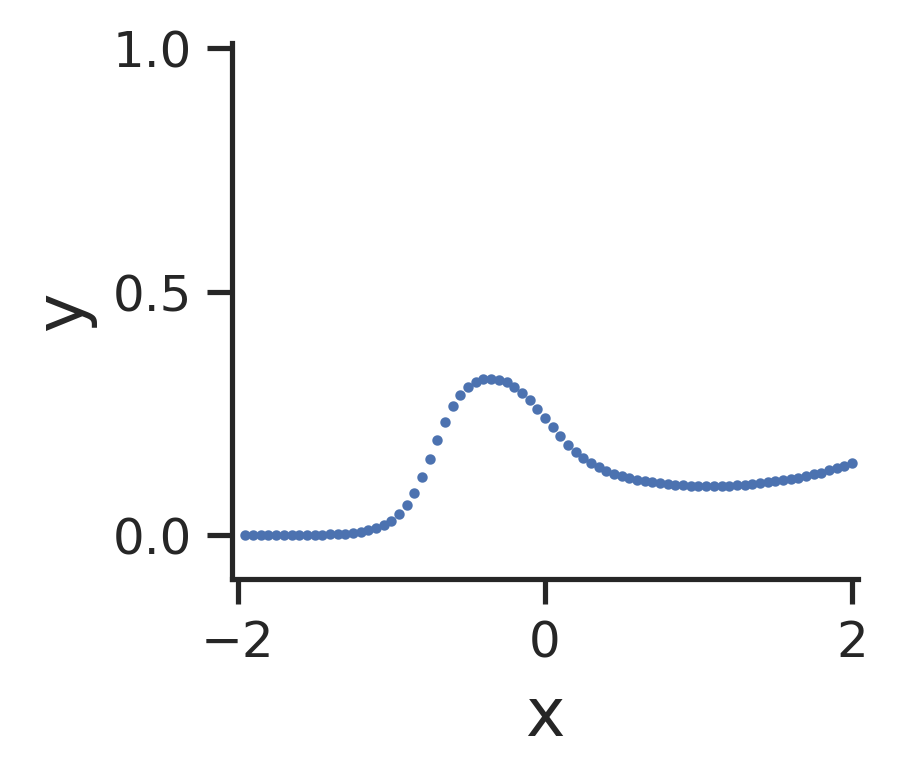

In [5]:
#Plot example function
#--------------------------------            
fig=figure(figsize=(width,height), dpi=300) 
plt.plot(dn.x1,dn.y,'.', markersize=marker_s)
#--------------------------------  

#Labels and ticks                                                              
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)                                                              
plt.xticks(xtick_labels, fontsize=size_ticks);plt.yticks(ytick_labels, fontsize=size_ticks)
plt.xlim(xmin,xmax);plt.ylim(ymin,ymax)

sns.despine(top=True, right=True);fig.tight_layout()

#save fig  
name_fig='observed_data'
for ext in extensions:
    plt.savefig(output_path+name_fig+ext,dpi=300)

plt.show()
#-------------------------------- 

# Suppose we approximate the function with a neural network:

![alt text](figures/ann_1.png "ANN with 5 layers and 10 nodes per layer")

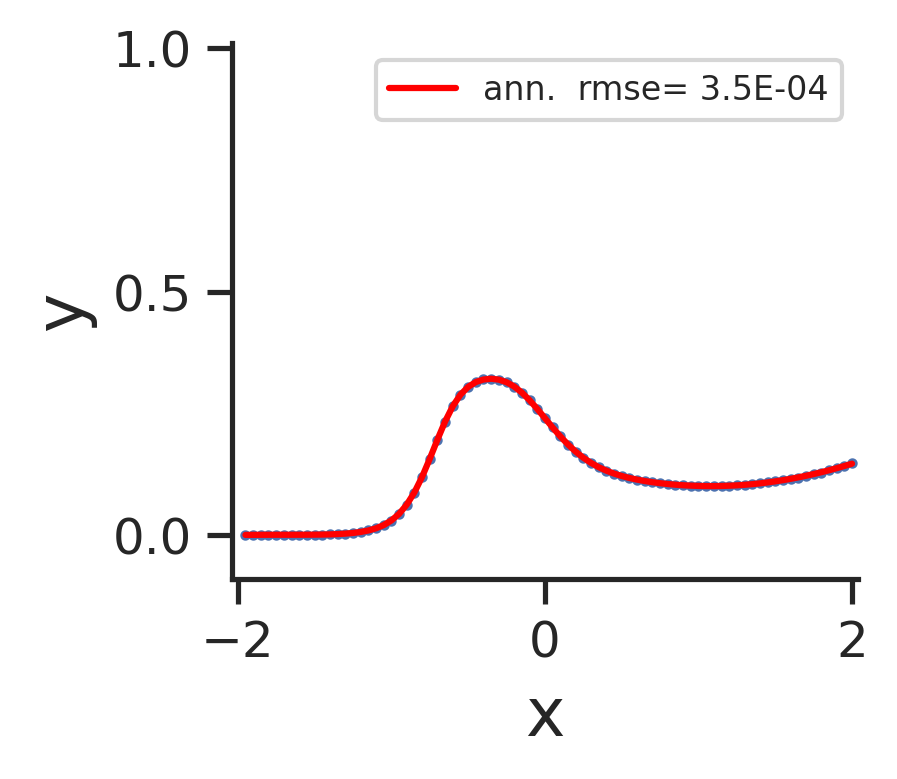

In [6]:
#Define figure
fig=figure(figsize=(width,height), dpi=300) 

#Root mean squared error
rmse_nn_total=root_mean_squared_error(dn.ymodel,dn.y)

#Plots                                                               
#--------------------------------                                    
plt.plot(dn.x1,dn.y,'.', markersize=marker_s)
plt.plot(dn.x1,dn.ymodel, color='red', label='ann.  rmse= %.1E' % rmse_nn_total)
#--------------------------------

#Labels                                                              
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
#Ticks                                                               
plt.xticks(xtick_labels, fontsize=size_ticks);plt.yticks(ytick_labels, fontsize=size_ticks)
plt.xlim(xmin,xmax);plt.ylim(ymin,ymax)

plt.legend(loc='best', fontsize=size_title)

sns.despine(top=True, right=True)
fig.tight_layout()

#save fig  
name_fig='ann_full_prediction'
for ext in extensions:
    plt.savefig(output_path+name_fig+ext,dpi=300)

plt.show()
#-------------------------------- 

# Suppose now that we train the Bayesian Machine Scientist with 10 parameters and let it sample the space in 50k steps

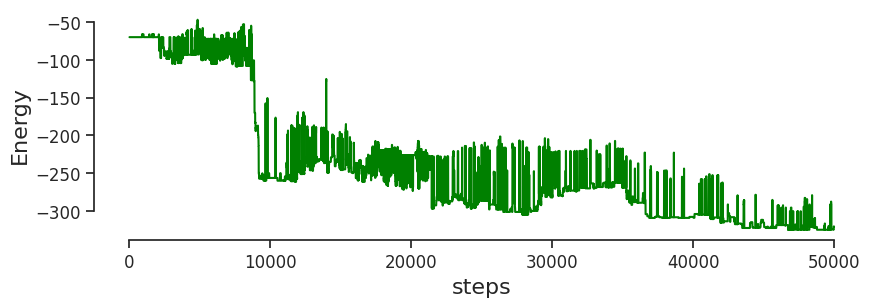

In [7]:
#Read  BMS data
NPAR=10;steps=50000

#Read trace
Nini = 00

#Plot energy vs steps
plt.figure(figsize=(10, 3))
minrow = trace0[trace0.H == min(trace0.H)].iloc[0]
#minH, minexpr, minparvals = minrow.H, minrow.expr, ast.literal_eval(minrow.parvals)

plt.plot(trace0.t[trace0.t > Nini], trace0.H[trace0.t > Nini],color='green')

plt.xlabel('steps',fontsize=size_axis);plt.ylabel('Energy',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)

sns.despine(trim=True)
namefig='Energy_' + activation_function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

for ext in extensions:
        plt.savefig(output_path + namefig + ext,dpi=300)

 
plt.show()

# Let's plot the approximation of the equation generated by the BMS

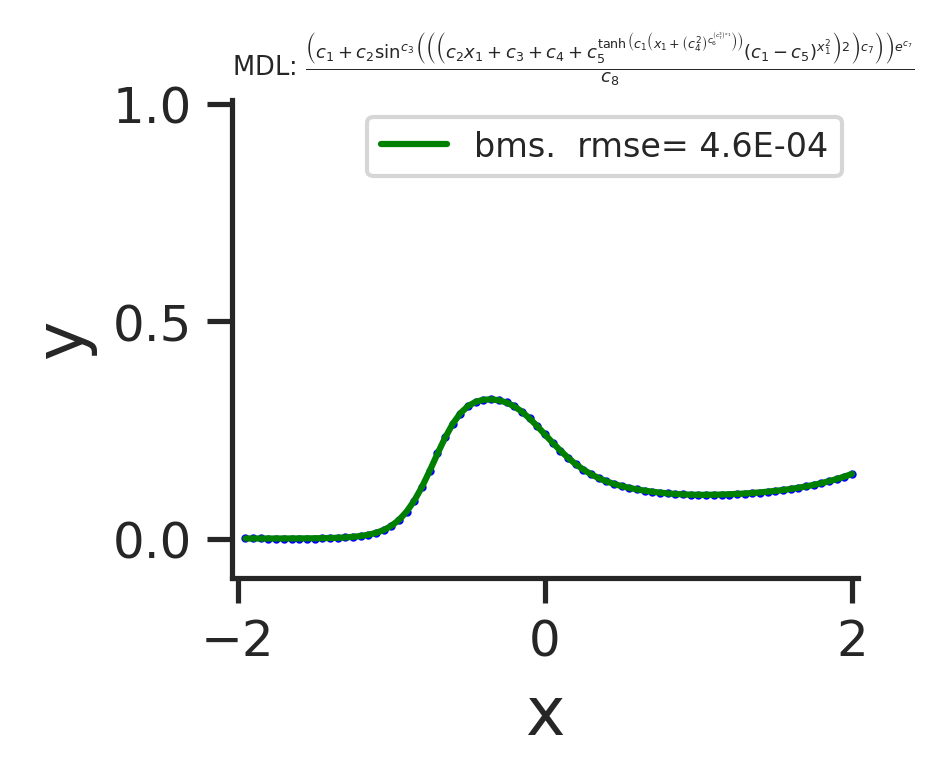

In [8]:

#copy the original dataframe and add a column for the prediction of the BMS
dplot = deepcopy(dn)
dplot['ybms'] = t0.predict(x0)

#calculate rmse
rmse_mdl=root_mean_squared_error(dplot['ybms'],dn['y'])

#Define figure size in cm                                                                                                                                   
fig=figure(figsize=(width,height), dpi=300) 
plt.plot(dn['x1'], dn['y'],'.', markersize=2, color='blue') 
plt.plot(dplot.x1, dplot.ybms, color='green',label='bms.  rmse= %.1E' % ( rmse_mdl))


plt.title('MDL: $%s$' % t0.latex(),loc='left',fontsize=size_title-1.8)
plt.xlabel('x',fontsize=size_axis);plt.ylabel("y",fontsize=size_axis)
plt.xticks(xtick_labels, fontsize=size_ticks);plt.yticks(ytick_labels, fontsize=size_ticks)
plt.xlim(xmin,xmax);plt.ylim(ymin,ymax)  

plt.legend(loc='best', fontsize=size_title)

sns.despine(top=True, right=True)
fig.tight_layout()

namefig='bms_full_prediction'

for ext in extensions:
        plt.savefig(output_path + namefig +ext,dpi=300)

plt.show()


## The equation found by the BMS approximates the same function with an error on the same order of magnitude and just 10 parameters

You think that is a complex equation? Probably, but bear in mind that the ANN that I showed you above performs 522 operations per data point. That function has 80 points.

Now, this is just an example, of course, so we do two experiments: 

### Experiment 1: Can ANNs and the BMS approximate actual mathematical functions?

 To see that, we take two functions from the [Nguyen Dataset](https://doi.org/10.1007/978-3-642-04962-0_7). In particular, we take function 1 and 10:

$$f_1=3.39 x^3 + 2.12 x^2 +  1.78 x$$

$$f_{10}=\sin(1.5 x) \cos(0.5 y)$$

First, we read the datasets.

In [9]:
#Read Nguyen data

#Read NN data
#-------------------------------------------------------------------------------
sigma=0.0;

realization=2

NPAR=10 #10, 20
steps=50000
resolution='1x' #'0.5x', '1x', '2x', 'test'
file_model='NN_no_overfit_sigma_' + str(sigma) + '_r_' + str(realization) + '.csv'
model_d='../../data/nguyen/' + resolution + '_resolution/trained_nns/' + file_model
dng=pd.read_csv(model_d,index_col=0)


#Read n1 trace
#-------------------------------------------------------------------------------
n1=1
dng1=dng[dng['rep']==1]
#Read bms trace for nguyen 1
filename='BMS_nguyen_n_' + str(n1)+'_sigma_'+str(sigma)+ '_r_' + str(realization) + '_id_0_trace_'+str(steps)+'_prior_10'+ '.csv'
trace1=pd.read_csv('../../data/MSTraces/nguyen/' + resolution + '_resolution/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])
t1,x1,y1=get_mdl(dng1, trace1)
#-------------------------------------------------------------------------------

#Read n10 trace
#-------------------------------------------------------------------------------
n2=10
dng10=dng[dng['rep']==n2]
dng10=dng10.reset_index(drop=True)
filename='BMS_nguyen_n_' + str(n2)+'_sigma_'+str(sigma)+ '_r_' + str(realization) + '_id_1_trace_'+str(steps)+'_prior_10'+ '.csv'
trace10=pd.read_csv('../../data/MSTraces/nguyen/' + resolution + '_resolution/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])
t10,x10,y10=get_mdl(dng10, trace10,dimensions=True)
#-------------------------------------------------------------------------------

### Then we plot the actual functions

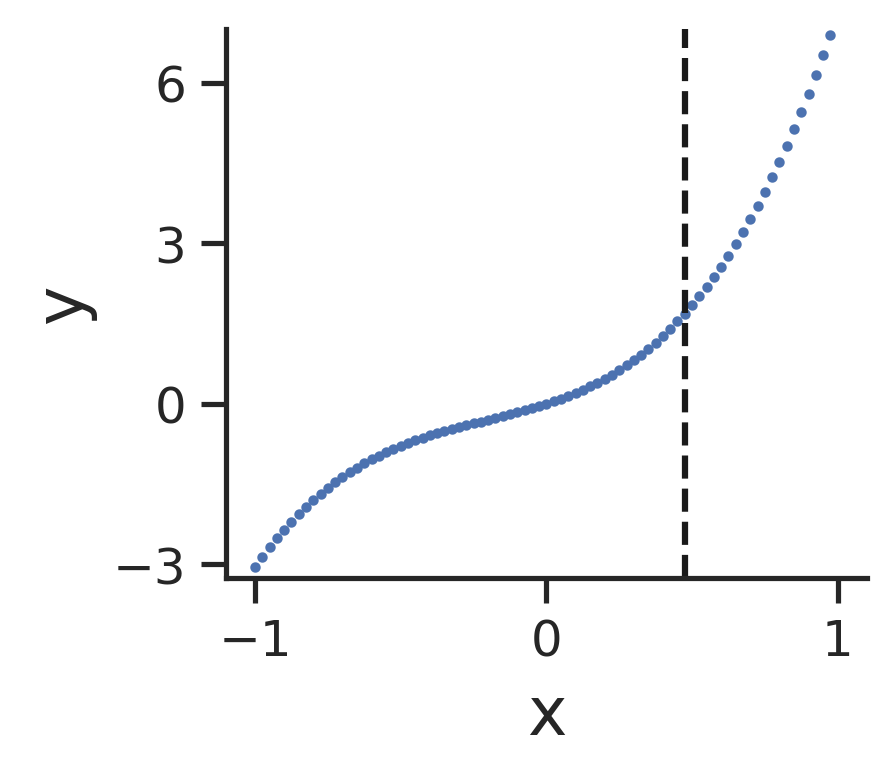

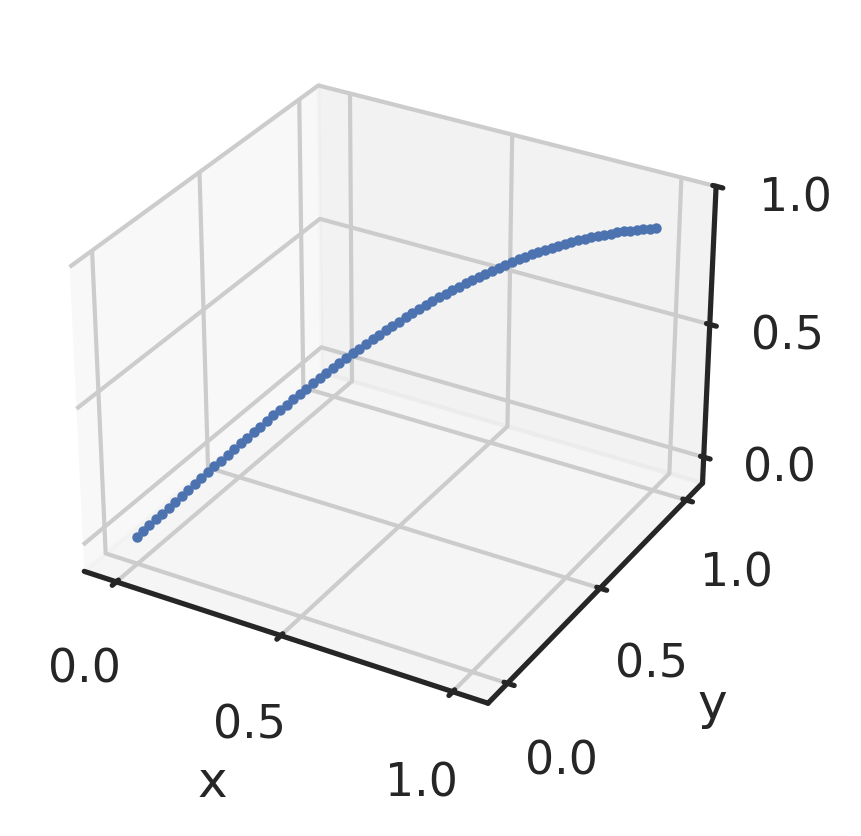

In [10]:
#Plot nguyen function 1

train_size=60
train_border=dng1.loc[train_size-1]['x']
#--------------------------------            
fig=figure(figsize=(width,height), dpi=300) 
plt.plot(dng1.x,dng1.z,'.', markersize=marker_s)

plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')
#plt.title(r'$f_1=3.39 x^3 + 2.12 x^2 +1.78x$',fontsize=size_title)
#-------------------------------- 


#Labels and ticks                                                              
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)                                                              
plt.xticks(xtick_labels_ng1, fontsize=size_ticks);plt.yticks(ytick_labels_ng1, fontsize=size_ticks)
plt.xlim(xmin_ng1,xmax_ng1);plt.ylim(ymin_ng1,ymax_ng1)

sns.despine(top=True, right=True)
fig.tight_layout()

#save fig  
name_fig='observed_nguyen'
for ext in extensions:
    plt.savefig(output_path+name_fig+ext,dpi=300)

plt.show()
#-------------------------------- 


#Plot nguyen function 10
#--------------------------------            
fig=figure(figsize=(width+20,height), dpi=300) 
ax=plt.subplot( projection='3d')
plt.plot(dng10.x,dng10.y, dng10.z,'.', markersize=marker_s)
#-------------------------------- 
#plt.title(r'$f_{10}=\sin(1.5x) \cos(0.5y)$',fontsize=size_title)

#Labels and ticks
ax.set_xlabel('x');ax.set_ylabel('y'); ax.set_zlabel('z')                                                       
ax.set_xticks(xtick_labels_ng10);ax.set_yticks(ytick_labels_ng10);ax.set_zticks(ztick_labels_ng10)
ax.set_xlim(xmin_ng10,xmax_ng10);ax.set_ylim(ymin_ng10,ymax_ng10);ax.set_zlim(zmin_ng10,zmax_ng10)

sns.despine(top=True, right=True)
fig.tight_layout()

#save fig  
name_fig='observed_nguyen'
for ext in extensions:
    plt.savefig(output_path+name_fig+ext,dpi=300)

plt.show()
#-------------------------------- 


### And now we plot the approximations of ANNs (red solid line) and the equation found by the BMS (solid green line) for $$f_1=3.39 x^3 + 2.12 x^2 +  1.78 x$$

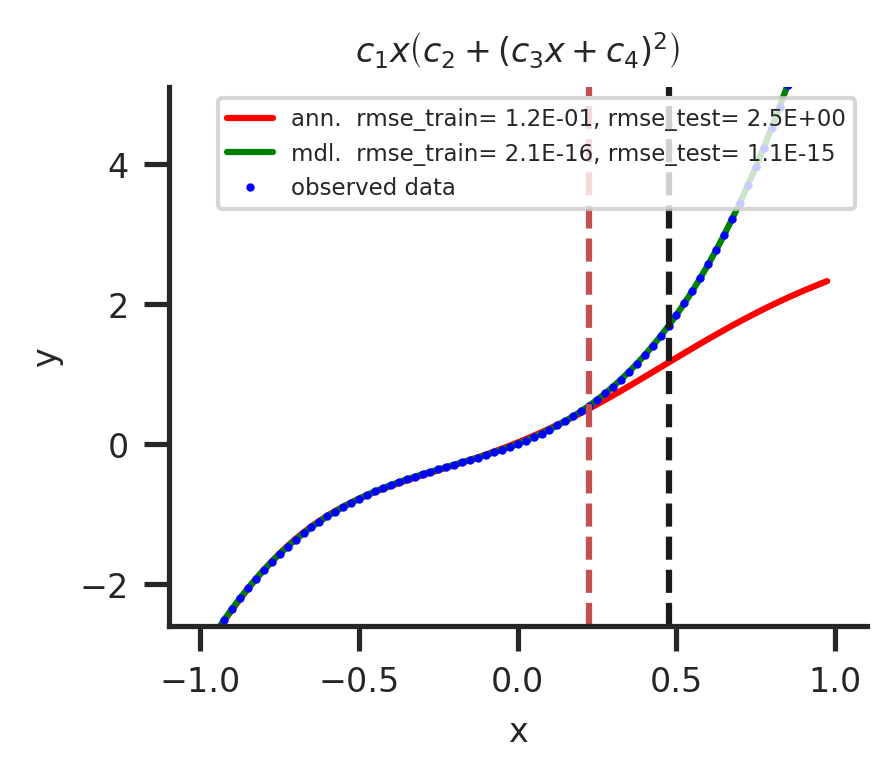

((_a2_ * x) * ((((x * _a0_) + _a3_) ** 2) + _a1_)) {'d0': {'_a0_': 2.128053445968343, '_a1_': 1.9350857962573627, '_a2_': 0.7485738229658999, '_a3_': 0.665409042102196, '_a4_': 1.0, '_a5_': 1.0, '_a6_': 1.0, '_a7_': 1.0}}


In [14]:
train_size_ann=50
train_size=60

validation_border=dng1.loc[train_size_ann-1]['x']
train_border=dng1.loc[train_size-1]['x']

dplot = deepcopy(dng1)
dplot['ybms'] = t1.predict(x1)

#Errors
rmse_nn_train=root_mean_squared_error(dplot.loc[:train_size-1]['zmodel'],dplot.loc[:train_size -1]['z'])
rmse_nn_test=root_mean_squared_error(dplot.loc[train_size-1:]['zmodel'],dplot.loc[train_size -1:]['z'])
rmse_mdl_train=root_mean_squared_error(dplot.loc[:train_size-1]['ybms'],dplot.loc[:train_size-1]['z'])
rmse_mdl_test =root_mean_squared_error(dplot.loc[train_size-1:]['ybms'],dplot.loc[train_size-1:]['z'])


#Plot figure
fig=figure(figsize=(width,height), dpi=300)                                                        
plt.plot(dng1['x'], dng1['zmodel'],linewidth=line_w, color='red', label='ann.  rmse_train= %.1E, rmse_test= %.1E' % ( rmse_nn_train, rmse_nn_test)) 
plt.plot(dplot.x, dplot.ybms, color='green',label='mdl.  rmse_train= %.1E, rmse_test= %.1E' % ( rmse_mdl_train, rmse_mdl_test)) 
plt.plot(dng1['x'], dng1['z'],'.', markersize=2, color='blue',label='observed data')  
                                                                                
plt.axvline(x=validation_border,linestyle='--',linewidth=line_w, color='r')
plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')


plt.title('$%s$' % t1.latex(),fontsize=size_title)
plt.xlabel('x',fontsize=size_title);plt.ylabel('y',fontsize=size_title)
plt.xticks(fontsize=size_title);plt.yticks(fontsize=size_title)

plt.legend(loc='best', fontsize=size_title-2.5)

plt.xlim(-1.1, 1.1);plt.ylim(-2.6,5.1)

sns.despine(top=True, right=True)
fig.tight_layout()

Name_figure='prediction_nguyen' + '_n_1' + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

    
for ext in extensions:
        plt.savefig('../../results/tutorial/' + Name_figure +ext,dpi=300)

plt.show()


print(t1,t1.par_values)

### We do the same for: $$f_{10}=\sin(1.5 x) \cos(0.5 y)$$

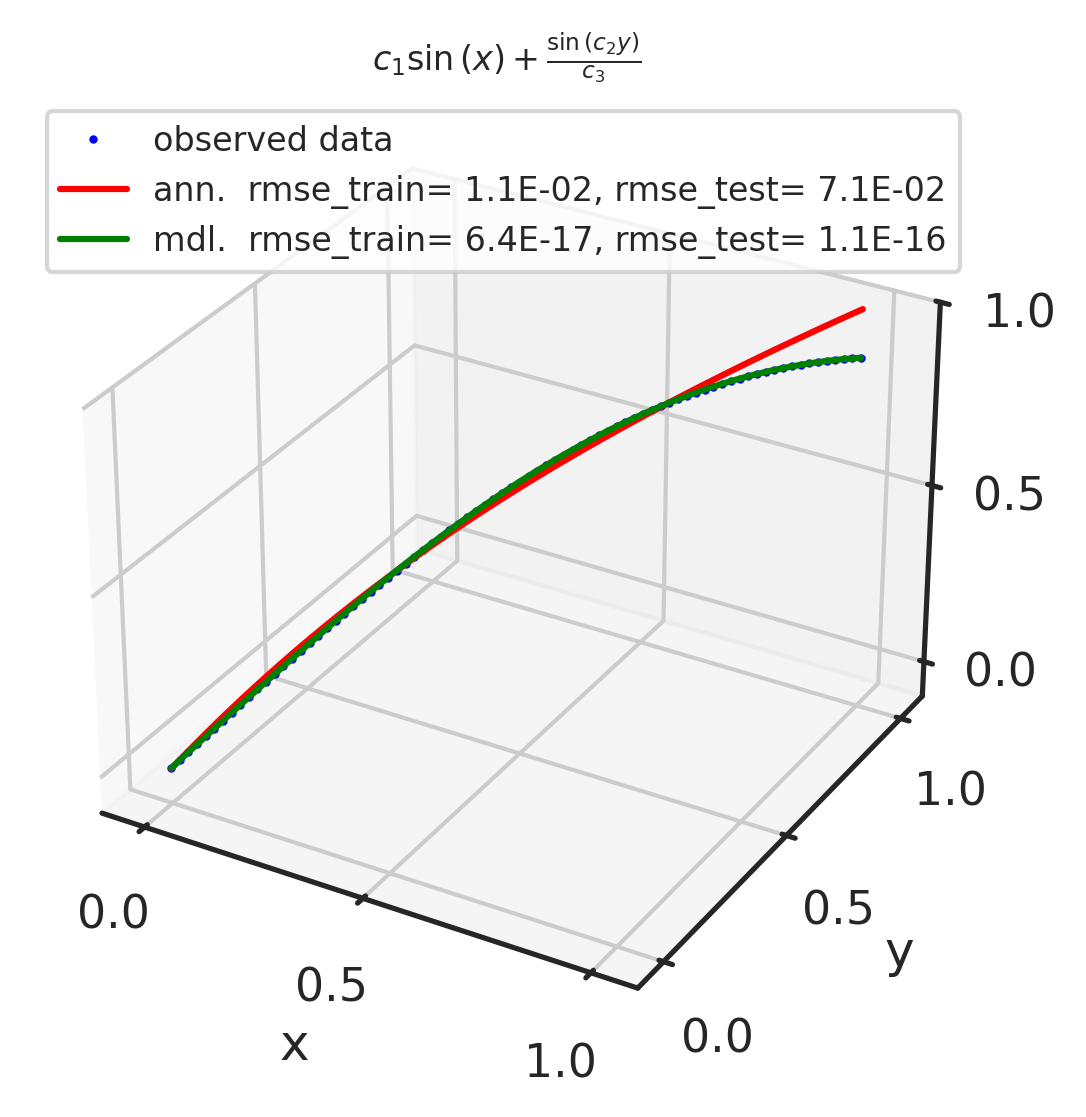

((sin(x) * _a5_) + (sin((y * _a2_)) / _a6_)) {'d0': {'_a2_': 1.9999999999999964, '_a5_': 0.49999999999999556, '_a6_': 1.9999999999999876, '_a0_': 1.0, '_a1_': 1.0, '_a3_': 1.0, '_a4_': 1.0, '_a7_': 1.0}}


In [16]:
#Plot 3d nguyen

dplot10 = deepcopy(dng10)

dplot10['ybms'] = t10.predict(x10)

#Errors
rmse_nn_train=root_mean_squared_error(dplot10.loc[:train_size-1]['zmodel'],dplot10.loc[:train_size -1]['z'])
rmse_nn_test=root_mean_squared_error(dplot10.loc[train_size-1:]['zmodel'],dplot10.loc[train_size -1:]['z'])
rmse_mdl_train=root_mean_squared_error(dplot10.loc[:train_size-1]['ybms'],dplot10.loc[:train_size-1]['z'])
rmse_mdl_test =root_mean_squared_error(dplot10.loc[train_size-1:]['ybms'],dplot10.loc[train_size-1:]['z'])

#Plot nguyen function 10
#--------------------------------            
fig=figure(figsize=(width+1,height+1), dpi=300) 
ax=plt.subplot( projection='3d')
#--------------------------------                                                        

plt.plot(dplot10.x, dplot10.y, dplot10.z,'.', markersize=2, color='blue',label='observed data') 
plt.plot(dplot10.x, dplot10.y, dplot10.zmodel,linewidth=line_w, color='red', label='ann.  rmse_train= %.1E, rmse_test= %.1E' % ( rmse_nn_train, rmse_nn_test)) 
plt.plot(dplot10.x, dplot10.y, dplot10.ybms, color='green',label='mdl.  rmse_train= %.1E, rmse_test= %.1E' % ( rmse_mdl_train, rmse_mdl_test))


plt.axvline(x=validation_border,linestyle='--',linewidth=line_w, color='r')
plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')


plt.title('$%s$' % t10.latex(),fontsize=size_title)
ax.set_xlabel('x',fontsize=size_ticks);ax.set_ylabel('y',fontsize=size_ticks)
ax.set_xticks(xtick_labels_ng10);ax.set_yticks(ytick_labels_ng10);ax.set_zticks(ztick_labels_ng10)
ax.set_xlim(xmin_ng10,xmax_ng10);ax.set_ylim(ymin_ng10,ymax_ng10);ax.set_zlim(zmin_ng10,zmax_ng10)
#plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)

ax.legend(loc='upper left', fontsize=size_title)
fig.tight_layout()


Name_figure='Prediction_nguyen' + '_n_' + str(n2) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

    
for ext in extensions:
        plt.savefig('../../results/tutorial/' + Name_figure +ext,dpi=300)

plt.show()


print(t10,t10.par_values)

### These are fairly good results, but to a certain extent expected: you would expect a good symbolic regression tool such as the Bayesian Machine Scientist to recover the functions that generated the data originally. Now, what happens if we try to approximate a function generated by an Artificial Neural Network?

### Experiment 2 -  Can ANNs and the BMS approximate ANN-generated functions?